In [238]:
import lightgbm as lgbm
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import optuna
from optuna.integration import LightGBMPruningCallback
import pandas as pd
import phik
import pickle
import re
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import BayesianRidge, ElasticNet, LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve, train_test_split, KFold
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.svm import SVR
from xgboost import XGBRegressor

In [239]:
## Best Result so far! ##
#with open('df_reduced.pkl', 'rb') as file:
#    df = pickle.load(file)
#df.reset_index(drop=True, inplace=True)

In [240]:
#with open('df_phik.pkl', 'rb') as file:
#    df = pickle.load(file)
#df.reset_index(drop=True, inplace=True)

In [269]:
with open('df_latest.pkl', 'rb') as file:
    df = pickle.load(file)
df.reset_index(drop=True, inplace=True)

## Test dataset with multiple models

In [248]:
from sklearn.linear_model import BayesianRidge, ElasticNet, LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='price'),
                                                    df['price'],
                                                    test_size=0.2,
                                                    random_state=42)

list_models = [BayesianRidge(),
               ElasticNet(),
               GradientBoostingRegressor(),
               LGBMRegressor(),
               LinearRegression(),
               RandomForestRegressor(),
               SGDRegressor(),
               SVR(),
               #XGBRegressor()
              ]

score_dict = {model.__class__.__name__: {'rmse': None, 'mae': None} for model in list_models}

for model in list_models:
    model_name = model.__class__.__name__

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    score_dict[model_name]['rmse'] = rmse
    score_dict[model_name]['mae'] = mae
    
    
    print(f'{model_name : <25} RMSE: {rmse : .4f}, MAE: {mae : .4f}')

BayesianRidge             RMSE:  0.6961, MAE:  0.5530
ElasticNet                RMSE:  0.8551, MAE:  0.6819
GradientBoostingRegressor RMSE:  0.6335, MAE:  0.4965
LGBMRegressor             RMSE:  0.6000, MAE:  0.4581
LinearRegression          RMSE:  0.6961, MAE:  0.5530
RandomForestRegressor     RMSE:  0.6180, MAE:  0.4691
SGDRegressor              RMSE:  1348645931081949.2500, MAE:  1215001256080356.5000
SVR                       RMSE:  0.9683, MAE:  0.7700


## Get top 3 models

In [249]:
# Sort the models based on RMSE values in ascending order
sorted_models = sorted(score_dict.items(), key=lambda x: x[1]['rmse'])
# Extract the lowest three models and their corresponding RMSE values
lowest_three = dict(sorted_models[:3])
# Create a new dictionary containing only the RMSE values of the lowest three models
rmse_dict = {model: values['rmse'] for model, values in lowest_three.items()}

print('sorted for lowest rmse')
rmse_dict

sorted for lowest rmse


{'LGBMRegressor': 0.5999997037376792,
 'RandomForestRegressor': 0.6179522741122918,
 'GradientBoostingRegressor': 0.6335282141008658}

In [250]:
# Sort the models based on MAE values in ascending order
sorted_models = sorted(score_dict.items(), key=lambda x: x[1]['mae'])
# Extract the lowest three models and their corresponding RMSE values
lowest_three = dict(sorted_models[:3])
# Create a new dictionary containing only the RMSE values of the lowest three models
mae_dict = {model: values['mae'] for model, values in lowest_three.items()}
print('sorted for lowest mae')
mae_dict

sorted for lowest mae


{'LGBMRegressor': 0.4581074325306247,
 'RandomForestRegressor': 0.46906695662575293,
 'GradientBoostingRegressor': 0.4965050506176344}

## Tune LGMBRegressor with Optuna

In [251]:
# Get categorical features for LGBMRegressor
cat_features = df.select_dtypes(include='category').columns.to_list()

def objective(trial, X, y):
    param_grid = {
        'objective': 'regression',
        'metric': 'rmse',
        'n_estimators': trial.suggest_categorical("n_estimators", [10000]),
        #'n_estimators': trial.suggest_int('n_estimators', 100, 10000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 3000, step=20),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 200, 10000, step=100),
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        'lambda_l1': trial.suggest_int('lambda_l1', 0, 100, step=5),
        'lambda_l2': trial.suggest_int('lambda_l2', 0, 100, step=5),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.2, 0.95, step=0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.95, step=0.1)
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores_rmse = np.empty(5)
    #cv_scores_mae = np.empty(5)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
                   
        model = LGBMRegressor(**param_grid)
        
        # Create dataset for LightGBM
        lgb_train = lgbm.Dataset(X_train, y_train, categorical_feature=cat_features)
        lgb_eval = lgbm.Dataset(X_test, y_test, reference=lgb_train)
        
        model.fit(X_train, y_train,
                  eval_set=[(X_test, y_test)],
                  # eval_metric=['l1', 'rmse'],
                  eval_metric='rmse',
                  categorical_feature=cat_features,
                  callbacks=[LightGBMPruningCallback(trial, 'rmse'),
                             lgbm.early_stopping(50)])

        y_pred = model.predict(X_test)
        
        # Calculate the evaluation metrics
        #mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        #cv_scores_mae[idx] = mae
        cv_scores_rmse[idx] = rmse

    return np.mean(cv_scores_rmse) #, np.mean(cv_scores_mae)

study = optuna.create_study(direction='minimize', study_name="LGBM Regressor")
func = lambda trial: objective(trial, df.drop(columns='price'), df['price'])
study.optimize(func, n_trials=20, show_progress_bar=True)

[I 2023-07-04 13:37:28,979] A new study created in memory with name: LGBM Regressor
  0%|                                                    | 0/20 [00:00<?, ?it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overr

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=13.577545896464459, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.577545896464459
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's rmse: 0.688125
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] min_data_in_leaf is set=2000

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/si

Best trial: 0. Best value: 0.66846:   5%|▍       | 1/20 [00:00<00:06,  2.98it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	valid_0's rmse: 0.673561
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=13.577545896464459, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.577545896464459
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	valid_0's rmse: 0.658942
[I 2023-07-04 13:37:29,3

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{c

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 327 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 328 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 329 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 330 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 503 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 504 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 505 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 506 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 682 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 683 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 684 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 685 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 861 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 862 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 863 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 864 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1046 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1047 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1048 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1049 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1228 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1229 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1230 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1231 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_

Early stopping, best iteration is:
[2216]	valid_0's rmse: 0.828907
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=2.157912180751922, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.157912180751922
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{c

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 391 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 392 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 393 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 394 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 530 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 531 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 532 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 533 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 675 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 676 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 677 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 678 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 815 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 816 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 817 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 818 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 957 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 958 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 959 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 960 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1098 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1099 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1100 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1101 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1241 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1242 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1243 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1244 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1384 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1385 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1386 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1387 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1526 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1527 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1528 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1529 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1668 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1669 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1670 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1671 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1812 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1813 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1814 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1815 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1956 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1957 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1958 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1959 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2101 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2102 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2103 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2104 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2246 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2247 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2248 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2249 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_

Early stopping, best iteration is:
[2202]	valid_0's rmse: 0.785735
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=2.157912180751922, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.157912180751922
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 385 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 386 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 387 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 388 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 525 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 526 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 527 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 528 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 669 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 670 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 671 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 672 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 810 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 811 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 812 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 813 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 952 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 953 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 954 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 955 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1094 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1095 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1096 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1097 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1235 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1236 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1237 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1238 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_

Early stopping, best iteration is:
[1223]	valid_0's rmse: 0.807372
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=2.157912180751922, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.157912180751922
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 360 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 361 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 362 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 363 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 500 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 501 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 502 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 503 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 644 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 645 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 646 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 647 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 785 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 786 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 787 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 788 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 928 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 929 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 930 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 931 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1071 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1072 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1073 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1074 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1213 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1214 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1215 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1216 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_

Best trial: 0. Best value: 0.66846:  10%|▊       | 2/20 [00:11<01:58,  6.56s/it]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

Early stopping, best iteration is:
[1223]	valid_0's rmse: 0.809018
[I 2023-07-04 13:37:40,234] Trial 1 finished with value: 0.8159534075863647 and parameters: {'n_estimators': 10000, 'learning_rate': 0.016924446444661758, 'num_leaves': 2240, 'max_depth': 3, 'min_data_in_leaf': 3200, 'max_bin': 201, 'lambda_l1': 95, 'lambda_l2': 60, 'min_gain_to_split': 2.157912180751922, 'bagging_fraction': 0.9, 'feature_fraction': 0.2}. Best is trial 0 with value: 0.6684603575482946.
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=8.494916367496387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.494916367496387
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3000000000

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
Best trial: 0. Best value: 0.66846:  15%|█▏      | 3/20 [00:11<01:02,  3.66s/it]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced b

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 0. Best value: 0.66846:  20%|█▌      | 4/20 [00:11<00:36,  2.28s/it]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

Early stopping, best iteration is:
[1]	valid_0's rmse: 0.990129
[I 2023-07-04 13:37:40,441] Trial 2 finished with value: 0.9999779050767257 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07666819576737063, 'num_leaves': 2340, 'max_depth': 10, 'min_data_in_leaf': 6700, 'max_bin': 216, 'lambda_l1': 85, 'lambda_l2': 10, 'min_gain_to_split': 8.494916367496387, 'bagging_fraction': 0.2, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: 0.6684603575482946.
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] min_data_in_leaf is set=7500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7500
[LightGBM] [Warning] min_gain_to_split is set=5.0069220166785176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.0069220166785176
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{c

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

Best trial: 0. Best value: 0.66846:  25%|██      | 5/20 [00:11<00:22,  1.53s/it]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[1]	valid_0's rmse: 1.01596
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] min_gain_to_split is set=13.23712390387508, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.23712390387508
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 1.01224
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categori

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 0. Best value: 0.66846:  30%|██▍     | 6/20 [00:12<00:15,  1.07s/it]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 1.01224
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] min_data_in_leaf is set=6900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6900
[LightGBM] [Warning] min_gain_to_split is set=2.806107788294651, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.806107788294651
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.989318
[LightGBM] [Warning] lambda_l

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{c

Early stopping, best iteration is:
[79]	valid_0's rmse: 0.666041
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=6.445035321010744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.445035321010744
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	valid_0's rmse: 0.663129


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/si

[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=6.445035321010744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.445035321010744
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{c

Early stopping, best iteration is:
[91]	valid_0's rmse: 0.637934
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=6.445035321010744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.445035321010744
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{c

Early stopping, best iteration is:
[92]	valid_0's rmse: 0.660873
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=6.445035321010744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.445035321010744
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[85]	valid_0's rmse: 0.649333


Best trial: 6. Best value: 0.655462:  35%|██▍    | 7/20 [00:13<00:13,  1.05s/it]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

[I 2023-07-04 13:37:42,011] Trial 6 finished with value: 0.6554619823207812 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08548965973548588, 'num_leaves': 1440, 'max_depth': 11, 'min_data_in_leaf': 1500, 'max_bin': 208, 'lambda_l1': 25, 'lambda_l2': 45, 'min_gain_to_split': 6.445035321010744, 'bagging_fraction': 0.30000000000000004, 'feature_fraction': 0.5}. Best is trial 6 with value: 0.6554619823207812.
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=14.561186198138019, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.561186198138019
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be i

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{c

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[1]	valid_0's rmse: 1.01224
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=7.7435580794461725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.7435580794461725
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.989318
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 

Best trial: 6. Best value: 0.655462:  55%|███▎  | 11/20 [00:13<00:03,  2.52it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

[I 2023-07-04 13:37:42,516] Trial 10 pruned. Trial was pruned at iteration 51.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's rmse: 0.65334
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=11.341927903740281, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.341927903740281
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
Training until validation scores don't improve for 50 rounds
Early stopping,

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/si

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{c

Best trial: 11. Best value: 0.646487:  60%|███  | 12/20 [00:13<00:03,  2.57it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

Early stopping, best iteration is:
[13]	valid_0's rmse: 0.628897
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=11.341927903740281, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.341927903740281
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's rmse: 0.650225
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: l

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{c

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[18]	valid_0's rmse: 0.658745
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=10.557112754201539, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.557112754201539
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's rmse: 0.656714
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: l

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 11. Best value: 0.646487:  65%|███▎ | 13/20 [00:14<00:02,  2.57it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

Early stopping, best iteration is:
[16]	valid_0's rmse: 0.658812
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=10.557112754201539, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.557112754201539
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 0.642196
[I 2023-07-04 13:37:43,274] Trial 12 finished with value: 0.6493993692932561 and paramete

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{c

Early stopping, best iteration is:
[16]	valid_0's rmse: 0.654681
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's rmse: 0.626104
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 wil

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 13. Best value: 0.64446:  70%|████▏ | 14/20 [00:14<00:02,  2.56it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

Early stopping, best iteration is:
[17]	valid_0's rmse: 0.638253
[I 2023-07-04 13:37:43,671] Trial 13 finished with value: 0.6444598843897994 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23767752014745283, 'num_leaves': 620, 'max_depth': 8, 'min_data_in_leaf': 300, 'max_bin': 258, 'lambda_l1': 30, 'lambda_l2': 0, 'min_gain_to_split': 10.982409437966773, 'bagging_fraction': 0.6000000000000001, 'feature_fraction': 0.9}. Best is trial 13 with value: 0.6444598843897994.
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=11.589114647588778, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.589114647588778
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM]

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{c

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


Early stopping, best iteration is:
[23]	valid_0's rmse: 0.655141
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.541140962352308, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.541140962352308
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 0.658337
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: l

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{c

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 13. Best value: 0.64446:  95%|█████▋| 19/20 [00:15<00:00,  5.30it/s]

Early stopping, best iteration is:
[19]	valid_0's rmse: 0.650804
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.541140962352308, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.541140962352308
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 0.63802
[I 2023-07-04 13:37:44,189] Trial 16 finished with value: 0.6455161211973763 and parameter

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters f

Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:37:44,387] Trial 19 pruned. Trial was pruned at iteration 51.


In [246]:
### TEST ###

# Get categorical features for LGBMRegressor
cat_features = df.select_dtypes(include='category').columns.to_list()

def objective(trial, X, y):
    param_grid = {
        'objective': 'regression',
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 3000, step=20),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 200, 10000, step=100),
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        'lambda_l1': trial.suggest_int('lambda_l1', 0, 100, step=5),
        'lambda_l2': trial.suggest_int('lambda_l2', 0, 100, step=5),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.2, 0.95, step=0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.95, step=0.1)
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores_mae = []
    cv_scores_rmse = []

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgbm.LGBMRegressor(**param_grid)

        # Create dataset for LightGBM
        lgb_train = lgbm.Dataset(X_train, y_train, categorical_feature=cat_features)
        lgb_eval = lgbm.Dataset(X_test, y_test, reference=lgb_train)

        model.fit(
            X_train, y_train,
            eval_set=[(X_test, y_test)],
            eval_metric=['l1', 'rmse'],
            categorical_feature=cat_features,
            callbacks=[LightGBMPruningCallback(trial, ['l1', 'rmse']), lgbm.early_stopping(50)],
            verbose=False
        )

        y_pred = model.predict(X_test)

        # Calculate the evaluation metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        cv_scores_mae.append(mae)
        cv_scores_rmse.append(rmse)

    return np.mean(cv_scores_mae), np.mean(cv_scores_rmse)

study = optuna.create_study(directions=['minimize', 'minimize'], study_name="LGBM Regressor")
func = lambda trial: objective(trial, df.drop(columns='price'), df['price'])
study.optimize(func, n_trials=20, show_progress_bar=True)

[I 2023-07-04 13:35:48,943] A new study created in memory with name: LGBM Regressor
  0%|                                                    | 0/20 [00:00<?, ?it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
 

[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] min_gain_to_split is set=6.37447274167074, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.37447274167074
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[W 2023-07-04 13:35:48,957] Trial 0 failed with parameters: {'n_estimators': 7400, 'learning_rate': 0.13814607888567818, 'num_leaves': 2880, 'max_depth': 9, 'min_data_in_leaf': 5100, 'max_bin': 237, 'lambda_l1': 10, 'lambda_l2': 85, 'min_gain_to_split': 6.37447274167074, 'bagging

ValueError: The entry associated with the validation name "valid_0" and the metric name "['l1', 'rmse']" is not found in the evaluation result list [('valid_0', 'l1', 0.8048600475485455, False), ('valid_0', 'rmse', 1.0159603989907264, False), ('valid_0', 'l2', 1.032175532317396, False)].

In [254]:
study.best_trial.value

0.6444598843897994

In [252]:
study.best_params

{'n_estimators': 10000,
 'learning_rate': 0.23767752014745283,
 'num_leaves': 620,
 'max_depth': 8,
 'min_data_in_leaf': 300,
 'max_bin': 258,
 'lambda_l1': 30,
 'lambda_l2': 0,
 'min_gain_to_split': 10.982409437966773,
 'bagging_fraction': 0.6000000000000001,
 'feature_fraction': 0.9}

In [255]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='price'),
                                                    df['price'],
                                                    test_size = 0.2,
                                                    random_state=42)
# Create the XGBoost model
model = LGBMRegressor(**study.best_params,  categorical_feature=cat_features)
# Set the training set sizes for the learning curve
train_sizes = np.linspace(0.1, 1.0, 10)

# Compute the learning curve scores
train_sizes, train_scores, test_scores = learning_curve(model,
                                                        X_train,
                                                        y_train, 
                                                        train_sizes=train_sizes, cv=5,
                                                        scoring='neg_mean_squared_error',
                                                        shuffle=True)

# Convert the scores to positive values and compute RMSE
train_scores = np.sqrt(-train_scores)
test_scores = np.sqrt(-test_scores)

# Compute the mean and standard deviation of the scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
 
score_dict=dict()
score_dict['train sizes'] = train_sizes
score_dict['train mean'] = train_mean
score_dict['test mean'] = test_mean
score_dict['train std'] = train_std
score_dict['test std'] = test_std

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/roman

[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.982409437966773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.982409437966773
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


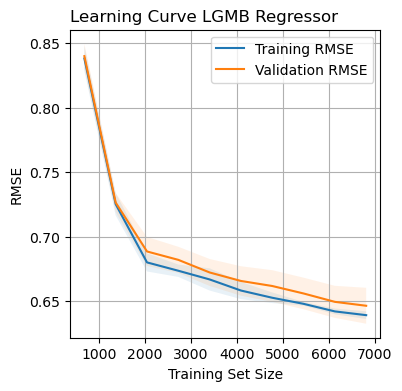

In [257]:
fig, ax = plt.subplots(figsize=(4,4))

ax.plot(train_sizes, train_mean, label='Training RMSE')
ax.plot(train_sizes, test_mean, label='Validation RMSE')
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

ax.set_xlabel('Training Set Size')
ax.set_ylabel('RMSE')
#ax.set_yticks(np.arange(0,100, 10))
ax.set_title(f'Learning Curve LGMB Regressor', loc='left')
ax.legend(loc='best')
ax.grid(True)

In [258]:
pd.DataFrame(score_dict)

train sizes  train mean  test mean  train std  test std
0          680    0.838244   0.840087   0.009616  0.009622
1         1361    0.725283   0.726532   0.008748  0.007394
2         2042    0.680142   0.688617   0.007022  0.011245
3         2723    0.673674   0.682119   0.004791  0.010153
4         3404    0.666932   0.672336   0.008612  0.010457
5         4084    0.658332   0.665759   0.006632  0.011406
6         4765    0.652727   0.661845   0.004110  0.012278
7         5446    0.648026   0.656052   0.001412  0.012257
8         6127    0.642149   0.649557   0.002246  0.012430
9         6808    0.639233   0.646525   0.002974  0.013930

| data | train sizes | train mean | test mean | train std | test std |
|-------------|-------------|------------|-----------|-----------|----------|
| df_reduced.pkl | 4084        | 53.927010  | 72.066524 | 0.642430  | 0.956300 |
| df_phik.pkl | 4765        | 37.759855  | 74.224214 | 0.441107  | 0.785615 |
| df_phik.pkl | 6808        | 58.556151  | 70.600408 | 0.127539  | 0.898457 |
 	 	 	 	

In [259]:
study.best_trial.value

0.6444598843897994

In [260]:
study.best_trial.params

{'n_estimators': 10000,
 'learning_rate': 0.23767752014745283,
 'num_leaves': 620,
 'max_depth': 8,
 'min_data_in_leaf': 300,
 'max_bin': 258,
 'lambda_l1': 30,
 'lambda_l2': 0,
 'min_gain_to_split': 10.982409437966773,
 'bagging_fraction': 0.6000000000000001,
 'feature_fraction': 0.9}

## Tune LGBM with Optuna

In [261]:
# Get categorical features for LGBMRegressor
cat_features = df.select_dtypes(include='category').columns.to_list()

def objective(trial, X, y):
    param_grid = {
        'objective': 'regression',
        'metric': 'l1',
        #'n_estimators': trial.suggest_categorical("n_estimators", [10000]),
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 3000, step=20),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 200, 10000, step=100),
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        'lambda_l1': trial.suggest_int('lambda_l1', 0, 100, step=5),
        'lambda_l2': trial.suggest_int('lambda_l2', 0, 100, step=5),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.2, 0.95, step=0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.95, step=0.1)
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    #cv_scores_rmse = np.empty(5)
    cv_scores_mae = np.empty(5)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
                   
        model = LGBMRegressor(**param_grid)
        
        # Create dataset for LightGBM
        lgb_train = lgbm.Dataset(X_train, y_train, categorical_feature=cat_features)
        lgb_eval = lgbm.Dataset(X_test, y_test, reference=lgb_train)
        
        model.fit(X_train, y_train,
                  eval_set=[(X_test, y_test)],
                  # eval_metric=['l1', 'rmse'],
                  eval_metric='l1',
                  categorical_feature=cat_features,
                  callbacks=[LightGBMPruningCallback(trial, 'l1'),
                             lgbm.early_stopping(50)])

        y_pred = model.predict(X_test)
        
        # Calculate the evaluation metrics
        mae = mean_absolute_error(y_test, y_pred)
        #rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        cv_scores_mae[idx] = mae
        #cv_scores_rmse[idx] = rmse

    return np.mean(cv_scores_mae) #, np.mean(cv_scores_rmse) 

study = optuna.create_study(direction='minimize', study_name="LGBM Regressor")
func = lambda trial: objective(trial, df.drop(columns='price'), df['price'])
study.optimize(func, n_trials=100, show_progress_bar=True)

[I 2023-07-04 13:45:43,165] A new study created in memory with name: LGBM Regressor
  0%|                                                   | 0/100 [00:00<?, ?it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overr

Best trial: 0. Best value: 0.798106:   1%|      | 1/100 [00:00<00:18,  5.29it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] min_gain_to_split is set=8.629743685962229, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.629743685962229
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.80486
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lamb

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{c

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[23]	valid_0's l1: 0.681715
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] min_gain_to_split is set=7.839807354307692, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.839807354307692
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 0.66285
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/si

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 1. Best value: 0.652232:   2%|      | 2/100 [00:00<00:27,  3.52it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

Early stopping, best iteration is:
[26]	valid_0's l1: 0.642687
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] min_gain_to_split is set=7.839807354307692, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.839807354307692
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 0.643035
[I 2023-07-04 13:45:43,709] Trial 1 finished with value: 0.652232187831238 and parameters: {'

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:4

Early stopping, best iteration is:
[30]	valid_0's l1: 0.514138
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=10.491123395403946, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.491123395403946
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's l1: 0.492985
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: l

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 2. Best value: 0.509275:   3%|▏     | 3/100 [00:00<00:34,  2.81it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

Early stopping, best iteration is:
[34]	valid_0's l1: 0.50063
[I 2023-07-04 13:45:44,150] Trial 2 finished with value: 0.5092750334483833 and parameters: {'n_estimators': 900, 'learning_rate': 0.12573616601415155, 'num_leaves': 2840, 'max_depth': 4, 'min_data_in_leaf': 1000, 'max_bin': 243, 'lambda_l1': 20, 'lambda_l2': 60, 'min_gain_to_split': 10.491123395403946, 'bagging_fraction': 0.2, 'feature_fraction': 0.9}. Best is trial 2 with value: 0.5092750334483833.
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=4.919688678907444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.919688678907444
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[Ligh

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{c

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

Early stopping, best iteration is:
[250]	valid_0's l1: 0.505849
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=4.919688678907444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.919688678907444
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

Early stopping, best iteration is:
[244]	valid_0's l1: 0.486364
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=4.919688678907444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.919688678907444
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

Early stopping, best iteration is:
[252]	valid_0's l1: 0.510907
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=4.919688678907444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.919688678907444
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

Best trial: 3. Best value: 0.50236:   4%|▎      | 4/100 [00:03<01:50,  1.15s/it]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068:

Best trial: 3. Best value: 0.50236:   5%|▎      | 5/100 [00:03<01:15,  1.25it/s]

Early stopping, best iteration is:
[248]	valid_0's l1: 0.493554
[I 2023-07-04 13:45:46,512] Trial 3 finished with value: 0.5023602044985773 and parameters: {'n_estimators': 4500, 'learning_rate': 0.02260432773277306, 'num_leaves': 2740, 'max_depth': 8, 'min_data_in_leaf': 900, 'max_bin': 269, 'lambda_l1': 0, 'lambda_l2': 20, 'min_gain_to_split': 4.919688678907444, 'bagging_fraction': 0.30000000000000004, 'feature_fraction': 0.6000000000000001}. Best is trial 3 with value: 0.5023602044985773.
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9700
[LightGBM] [Warning] min_gain_to_split is set=7.06558332297493, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.06558332297493
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[L

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters f

[I 2023-07-04 13:45:46,725] Trial 5 pruned. Trial was pruned at iteration 19.
[I 2023-07-04 13:45:46,740] Trial 6 pruned. Trial was pruned at iteration 0.
[I 2023-07-04 13:45:46,754] Trial 7 pruned. Trial was pruned at iteration 0.
[I 2023-07-04 13:45:46,769] Trial 8 pruned. Trial was pruned at iteration 0.
[I 2023-07-04 13:45:46,783] Trial 9 pruned. Trial was pruned at iteration 0.
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{c

Early stopping, best iteration is:
[65]	valid_0's l1: 0.514647
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.8107253747242757, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8107253747242757
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	valid_0's l1: 0.506509
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will 

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[66]	valid_0's l1: 0.486753
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.8107253747242757, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8107253747242757
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	valid_0's l1: 0.509296
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will 

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 10. Best value: 0.502032:  11%|▍   | 11/100 [00:04<00:28,  3.11it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

Early stopping, best iteration is:
[74]	valid_0's l1: 0.492956
[I 2023-07-04 13:45:47,692] Trial 10 finished with value: 0.5020319892789407 and parameters: {'n_estimators': 8800, 'learning_rate': 0.08852812033899014, 'num_leaves': 2980, 'max_depth': 10, 'min_data_in_leaf': 200, 'max_bin': 278, 'lambda_l1': 50, 'lambda_l2': 30, 'min_gain_to_split': 3.8107253747242757, 'bagging_fraction': 0.6000000000000001, 'feature_fraction': 0.5}. Best is trial 10 with value: 0.5020319892789407.
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.5018102265748707, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5018102265748707
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [

Best trial: 10. Best value: 0.502032:  12%|▍   | 12/100 [00:04<00:26,  3.29it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

[I 2023-07-04 13:45:47,899] Trial 11 pruned. Trial was pruned at iteration 118.
[I 2023-07-04 13:45:47,939] Trial 12 pruned. Trial was pruned at iteration 0.
[I 2023-07-04 13:45:47,982] Trial 13 pruned. Trial was pruned at iteration 0.
[I 2023-07-04 13:45:48,025] Trial 14 pruned. Trial was pruned at iteration 0.
[I 2023-07-04 13:45:48,066] Trial 15 pruned. Trial was pruned at iteration 0.


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
Best trial: 10. Best value: 0.502032:  16%|▋   | 16/100 [00:04<00:16,  4.99it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in

[I 2023-07-04 13:45:48,107] Trial 16 pruned. Trial was pruned at iteration 0.
Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:45:48,268] Trial 17 pruned. Trial was pruned at iteration 76.


Best trial: 10. Best value: 0.502032:  18%|▋   | 18/100 [00:05<00:12,  6.36it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

[I 2023-07-04 13:45:48,311] Trial 18 pruned. Trial was pruned at iteration 0.
[I 2023-07-04 13:45:48,353] Trial 19 pruned. Trial was pruned at iteration 0.
[I 2023-07-04 13:45:48,392] Trial 20 pruned. Trial was pruned at iteration 0.
Training until validation scores don't improve for 50 rounds


Best trial: 10. Best value: 0.502032:  21%|▊   | 21/100 [00:05<00:09,  8.49it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

[I 2023-07-04 13:45:48,526] Trial 21 pruned. Trial was pruned at iteration 76.
Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:45:48,640] Trial 22 pruned. Trial was pruned at iteration 76.
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{c

Early stopping, best iteration is:
[34]	valid_0's l1: 0.504572
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.497382942924202, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.497382942924202
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's l1: 0.499859
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will 

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{c

Early stopping, best iteration is:
[38]	valid_0's l1: 0.475445
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.497382942924202, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.497382942924202
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's l1: 0.502368
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will 

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

Best trial: 23. Best value: 0.493303:  23%|▉   | 23/100 [00:06<00:09,  8.38it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

Early stopping, best iteration is:
[36]	valid_0's l1: 0.48427
[I 2023-07-04 13:45:49,312] Trial 23 finished with value: 0.49330270513983693 and parameters: {'n_estimators': 5500, 'learning_rate': 0.14149602590238797, 'num_leaves': 2780, 'max_depth': 6, 'min_data_in_leaf': 200, 'max_bin': 234, 'lambda_l1': 15, 'lambda_l2': 90, 'min_gain_to_split': 3.497382942924202, 'bagging_fraction': 0.30000000000000004, 'feature_fraction': 0.9}. Best is trial 23 with value: 0.49330270513983693.
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] min_gain_to_split is set=4.092547626032866, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.092547626032866
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters f

[I 2023-07-04 13:45:49,515] Trial 26 pruned. Trial was pruned at iteration 0.
[I 2023-07-04 13:45:49,560] Trial 27 pruned. Trial was pruned at iteration 0.
[I 2023-07-04 13:45:49,603] Trial 28 pruned. Trial was pruned at iteration 0.
[I 2023-07-04 13:45:49,645] Trial 29 pruned. Trial was pruned at iteration 0.
[I 2023-07-04 13:45:49,687] Trial 30 pruned. Trial was pruned at iteration 0.


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{c

Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:45:49,824] Trial 31 pruned. Trial was pruned at iteration 82.
Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:45:49,872] Trial 32 pruned. Trial was pruned at iteration 3.
Training until validation scores don't improve for 50 rounds


Best trial: 23. Best value: 0.493303:  33%|█▎  | 33/100 [00:06<00:06,  9.74it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

[I 2023-07-04 13:45:50,000] Trial 33 pruned. Trial was pruned at iteration 76.
Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:45:50,102] Trial 34 pruned. Trial was pruned at iteration 51.
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{c

Early stopping, best iteration is:
[25]	valid_0's l1: 0.50548
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.2140102066998795, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.2140102066998795
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 0.500882
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[25]	valid_0's l1: 0.477026
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.2140102066998795, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.2140102066998795
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 0.503434
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[26]	valid_0's l1: 0.483057
[I 2023-07-04 13:45:50,653] Trial 35 finished with value: 0.49397581832722504 and parameters: {'n_estimators': 6400, 'learning_rate': 0.1804013666997418, 'num_leaves': 2460, 'max_depth': 5, 'min_data_in_leaf': 200, 'max_bin': 230, 'lambda_l1': 5, 'lambda_l2': 50, 'min_gain_to_split': 5.2140102066998795, 'bagging_fraction': 0.4, 'feature_fraction': 0.9}. Best is trial 23 with value: 0.49330270513983693.
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=5.188813501107818, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.188813501107818
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fra

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[27]	valid_0's l1: 0.504285
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=5.188813501107818, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.188813501107818
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's l1: 0.481671
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{c

Best trial: 23. Best value: 0.493303:  37%|█▍  | 37/100 [00:07<00:13,  4.57it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

Early stopping, best iteration is:
[27]	valid_0's l1: 0.489672
[I 2023-07-04 13:45:51,152] Trial 36 finished with value: 0.4988327461073501 and parameters: {'n_estimators': 6400, 'learning_rate': 0.18307893674040437, 'num_leaves': 2480, 'max_depth': 5, 'min_data_in_leaf': 500, 'max_bin': 230, 'lambda_l1': 5, 'lambda_l2': 40, 'min_gain_to_split': 5.188813501107818, 'bagging_fraction': 0.4, 'feature_fraction': 0.8}. Best is trial 23 with value: 0.49330270513983693.
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.796008495600478, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.796008495600478
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_frac

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:49

Early stopping, best iteration is:
[23]	valid_0's l1: 0.50639
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.796008495600478, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.796008495600478
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 0.480892
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

Best trial: 23. Best value: 0.493303:  38%|█▌  | 38/100 [00:08<00:16,  3.84it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

Early stopping, best iteration is:
[23]	valid_0's l1: 0.487935
[I 2023-07-04 13:45:51,629] Trial 37 finished with value: 0.4978737948759072 and parameters: {'n_estimators': 6700, 'learning_rate': 0.18477335755985017, 'num_leaves': 2440, 'max_depth': 5, 'min_data_in_leaf': 200, 'max_bin': 216, 'lambda_l1': 5, 'lambda_l2': 55, 'min_gain_to_split': 7.796008495600478, 'bagging_fraction': 0.5, 'feature_fraction': 0.8}. Best is trial 23 with value: 0.49330270513983693.
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=7.2185439428933575, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.2185439428933575
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fr

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters f

[I 2023-07-04 13:45:51,832] Trial 40 pruned. Trial was pruned at iteration 16.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	valid_0's l1: 0.506122
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.275463351107016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.275463351107016
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
Training until validation scores don't improve fo

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[32]	valid_0's l1: 0.501163
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.275463351107016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.275463351107016
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's l1: 0.477589
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ig

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[32]	valid_0's l1: 0.502625
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.275463351107016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.275463351107016
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's l1: 0.484275
[I 2023-07-04 13:45:52,411] Trial 41 finished with value: 0.49435

Best trial: 23. Best value: 0.493303:  43%|█▋  | 43/100 [00:09<00:12,  4.42it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

[I 2023-07-04 13:45:52,519] Trial 42 pruned. Trial was pruned at iteration 51.
Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:45:52,617] Trial 43 pruned. Trial was pruned at iteration 50.
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{c

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{c

Early stopping, best iteration is:
[21]	valid_0's l1: 0.507862
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.309071516373671, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.309071516373671
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's l1: 0.503435
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will 

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:4

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:4

Best trial: 23. Best value: 0.493303:  45%|█▊  | 45/100 [00:09<00:13,  4.10it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

Early stopping, best iteration is:
[20]	valid_0's l1: 0.504426
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.309071516373671, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.309071516373671
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's l1: 0.487747
[I 2023-07-04 13:45:53,080] Trial 44 finished with value: 0.4

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters f

Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:45:53,267] Trial 46 pruned. Trial was pruned at iteration 51.
[I 2023-07-04 13:45:53,309] Trial 47 pruned. Trial was pruned at iteration 0.
[I 2023-07-04 13:45:53,349] Trial 48 pruned. Trial was pruned at iteration 0.
Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:45:53,392] Trial 49 pruned. Trial was pruned at iteration 1.


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters f

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

[I 2023-07-04 13:45:53,434] Trial 50 pruned. Trial was pruned at iteration 0.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 0.50538
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.452141549917247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.452141549917247
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[28]	valid_0's l1: 0.500064
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.452141549917247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.452141549917247
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's l1: 0.478089
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 23. Best value: 0.493303:  52%|██  | 52/100 [00:10<00:08,  5.76it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	valid_0's l1: 0.487826
[I 2023-07-04 13:45:53,945] Trial 51 finished with value: 0.49520450996255283 and parameters: {'n_estimators': 6200, 'learning_rate': 0.17888062976242747, 'num_leaves': 2380, 'max_depth': 5, 'min_data_in_leaf': 400, 'max_bin': 230, 'lambda_l1': 5, 'lambda_l2': 40, 'min_gain_to_split': 5.452141549917247, 'bagging_fraction': 0.4, 'feature_fraction': 0.8}. Best is trial 23 with value: 0.49330270513983693.
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=5.525664604211637, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.525664604211637
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Curre

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters f

Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:45:54,090] Trial 53 pruned. Trial was pruned at iteration 13.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	valid_0's l1: 0.506359
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.622247863293345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.622247863293345
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
Training until v

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/si

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[26]	valid_0's l1: 0.501867
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.622247863293345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.622247863293345
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 0.481743
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambd

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065

Best trial: 23. Best value: 0.493303:  54%|██▏ | 54/100 [00:11<00:06,  6.90it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

Early stopping, best iteration is:
[27]	valid_0's l1: 0.488189
[I 2023-07-04 13:45:54,593] Trial 54 finished with value: 0.49642194548999363 and parameters: {'n_estimators': 8200, 'learning_rate': 0.20145401470830035, 'num_leaves': 2080, 'max_depth': 6, 'min_data_in_leaf': 200, 'max_bin': 217, 'lambda_l1': 20, 'lambda_l2': 35, 'min_gain_to_split': 4.622247863293345, 'bagging_fraction': 0.4, 'feature_fraction': 0.7}. Best is trial 23 with value: 0.49330270513983693.
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] min_gain_to_split is set=4.411725826588942, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.411725826588942
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] baggin

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters f

Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:45:54,819] Trial 58 pruned. Trial was pruned at iteration 11.
[I 2023-07-04 13:45:54,863] Trial 59 pruned. Trial was pruned at iteration 0.
[I 2023-07-04 13:45:54,906] Trial 60 pruned. Trial was pruned at iteration 0.
Training until validation scores don't improve for 50 rounds


Best trial: 23. Best value: 0.493303:  62%|██▍ | 62/100 [00:11<00:04,  9.47it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

[I 2023-07-04 13:45:55,010] Trial 61 pruned. Trial was pruned at iteration 51.
Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:45:55,083] Trial 62 pruned. Trial was pruned at iteration 13.
Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:45:55,144] Trial 63 pruned. Trial was pruned at iteration 12.
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{c

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[27]	valid_0's l1: 0.50577
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=6.26710901659592, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.26710901659592
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's l1: 0.501305
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameter

Best trial: 23. Best value: 0.493303:  64%|██▌ | 64/100 [00:12<00:03, 10.63it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's l1: 0.504389
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=6.26710901659592, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.26710901659592
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's l1: 0.49013
[I 2023-07-04 13:45:55,642] Trial 64 

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters f

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=6.370031532829851, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.370031532829851
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:45:55,693] Trial 65 pruned. Trial was pruned at iteration 4.
Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:4

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters f

Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:45:55,967] Trial 69 pruned. Trial was pruned at iteration 71.
Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:45:56,038] Trial 70 pruned. Trial was pruned at iteration 12.
Training until validation scores don't improve for 50 rounds


Best trial: 23. Best value: 0.493303:  72%|██▉ | 72/100 [00:12<00:02,  9.67it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

[I 2023-07-04 13:45:56,150] Trial 71 pruned. Trial was pruned at iteration 51.
Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:45:56,274] Trial 72 pruned. Trial was pruned at iteration 71.
Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:45:56,334] Trial 73 pruned. Trial was pruned at iteration 9.


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters f

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

[I 2023-07-04 13:45:56,379] Trial 74 pruned. Trial was pruned at iteration 0.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 0.503101
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
Training until validation scores don't improve for

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/si

Early stopping, best iteration is:
[25]	valid_0's l1: 0.497452
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's l1: 0.473501
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ig

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 75. Best value: 0.492178:  76%|███ | 76/100 [00:13<00:03,  6.46it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 0.483637
[I 2023-07-04 13:45:56,900] Trial 75 finished with value: 0.49217833481272144 and parameters: {'n_estimators': 7100, 'learning_r

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{c

[I 2023-07-04 13:45:57,011] Trial 77 pruned. Trial was pruned at iteration 7.
Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:45:57,070] Trial 78 pruned. Trial was pruned at iteration 8.
Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:45:57,119] Trial 79 pruned. Trial was pruned at iteration 3.
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{c

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[19]	valid_0's l1: 0.506373
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.210194287867268, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.210194287867268
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	valid_0's l1: 0.500499
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[19]	valid_0's l1: 0.506234
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.210194287867268, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.210194287867268
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 0.488352
[I 2023-07-04 13:45:57,564] Trial 80 finished with value: 0.496

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters f

Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:45:57,750] Trial 82 pruned. Trial was pruned at iteration 14.
Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:45:57,815] Trial 83 pruned. Trial was pruned at iteration 12.
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{c

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068:

Early stopping, best iteration is:
[21]	valid_0's l1: 0.505066
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.985866426902775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.985866426902775
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 0.498869
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:49

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 75. Best value: 0.492178:  84%|███▎| 84/100 [00:15<00:02,  7.68it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

Early stopping, best iteration is:
[20]	valid_0's l1: 0.504267
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.985866426902775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.985866426902775
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	valid_0's l1: 0.485528
[I 2023-07-04 13:45:58,286] Trial 84 finished with value: 0.49392679777493315 and parameters: {

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters f

Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:45:58,471] Trial 86 pruned. Trial was pruned at iteration 23.
Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:45:58,520] Trial 87 pruned. Trial was pruned at iteration 4.
[I 2023-07-04 13:45:58,567] Trial 88 pruned. Trial was pruned at iteration 0.
[I 2023-07-04 13:45:58,611] Trial 89 pruned. Trial was pruned at iteration 0.


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters f

Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:45:58,671] Trial 90 pruned. Trial was pruned at iteration 7.
Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:45:58,778] Trial 91 pruned. Trial was pruned at iteration 51.
Training until validation scores don't improve for 50 rounds


Best trial: 75. Best value: 0.492178:  93%|███▋| 93/100 [00:15<00:00,  9.55it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

[I 2023-07-04 13:45:58,867] Trial 92 pruned. Trial was pruned at iteration 27.
Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:45:58,944] Trial 93 pruned. Trial was pruned at iteration 17.
[I 2023-07-04 13:45:58,990] Trial 94 pruned. Trial was pruned at iteration 0.
Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:45:59,045] Trial 95 pruned. Trial was pruned at iteration 2.


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['host_response_time', 'host_verifications', 'property_type', 'room_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters f

Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:45:59,095] Trial 96 pruned. Trial was pruned at iteration 2.
[I 2023-07-04 13:45:59,142] Trial 97 pruned. Trial was pruned at iteration 0.
[I 2023-07-04 13:45:59,189] Trial 98 pruned. Trial was pruned at iteration 0.
Training until validation scores don't improve for 50 rounds
[I 2023-07-04 13:45:59,274] Trial 99 pruned. Trial was pruned at iteration 23.


In [262]:
study.best_trial.value

0.49217833481272144

In [263]:
study.best_params

{'n_estimators': 7100,
 'learning_rate': 0.21385840356412333,
 'num_leaves': 1980,
 'max_depth': 6,
 'min_data_in_leaf': 400,
 'max_bin': 212,
 'lambda_l1': 5,
 'lambda_l2': 90,
 'min_gain_to_split': 3.194945817403606,
 'bagging_fraction': 0.6000000000000001,
 'feature_fraction': 0.9}

In [264]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='price'),
                                                    df['price'],
                                                    test_size = 0.2,
                                                    random_state=42)
# Create the XGBoost model
model = LGBMRegressor(**study.best_params,  categorical_feature=cat_features)
# Set the training set sizes for the learning curve
train_sizes = np.linspace(0.1, 1.0, 10)

# Compute the learning curve scores
train_sizes, train_scores, test_scores = learning_curve(model,
                                                        X_train,
                                                        y_train, 
                                                        train_sizes=train_sizes, cv=5,
                                                        scoring='neg_mean_absolute_error',
                                                        shuffle=True)

# Convert the scores to positive values and compute RMSE
train_scores = -train_scores
test_scores = -test_scores

# Compute the mean and standard deviation of the scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
 
score_dict=dict()
score_dict['train sizes'] = train_sizes
score_dict['train mean'] = train_mean
score_dict['test mean'] = test_mean
score_dict['train std'] = train_std
score_dict['test std'] = test_std

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/roman

[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.194945817403606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.194945817403606
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


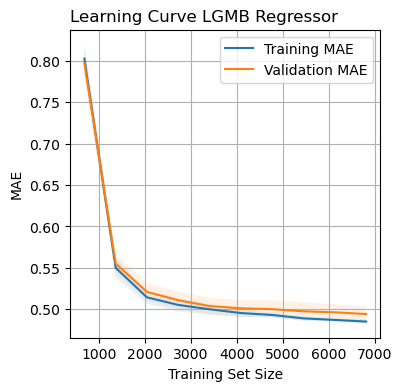

In [267]:
fig, ax = plt.subplots(figsize=(4,4))

ax.plot(train_sizes, train_mean, label='Training MAE')
ax.plot(train_sizes, test_mean, label='Validation MAE')
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

ax.set_xlabel('Training Set Size')
ax.set_ylabel('MAE')
#ax.set_yticks(np.arange(0,70, 10))
ax.set_title(f'Learning Curve LGMB Regressor', loc='left')
ax.legend(loc='best')
ax.grid(True)